Attention Analysis

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

class CausalSelfAttention(nn.Module):
    def __init__(self, d_model, n_heads):
        """
        Causal Self-Attention
        
        This is the most important part of the model.
        It allows the model to focus on relevant previous words.
        
        Args:
            d_model: Embedding dimension (256)
            n_heads: Number of attention heads (4)
        """
        super().__init__()
        assert d_model % n_heads == 0, "d_model must be divisible by n_heads"
        
        self.d_model = d_model
        self.n_heads = n_heads
        self.head_dim = d_model // n_heads
        
        # Linear layers for Q, K, V
        self.q_proj = nn.Linear(d_model, d_model)
        self.k_proj = nn.Linear(d_model, d_model)
        self.v_proj = nn.Linear(d_model, d_model)
        
        # Output projection
        self.out_proj = nn.Linear(d_model, d_model)
        
        # Dropout for regularization
        self.attn_dropout = nn.Dropout(0.1)
        self.resid_dropout = nn.Dropout(0.1)
        
    def forward(self, x):
        """
        Forward pass
        
        Args:
            x: Input tensor, shape (batch_size, seq_len, d_model)
        
        Returns:
            Output tensor, shape (batch_size, seq_len, d_model)
        """
        B, T, C = x.shape  # Batch, Time (sequence length), Channels (d_model)
        
        # Calculate Q, K, V
        Q = self.q_proj(x)  # (B, T, d_model)
        K = self.k_proj(x)  # (B, T, d_model)
        V = self.v_proj(x)  # (B, T, d_model)
        
        # Split into multiple heads
        # (B, T, d_model) -> (B, T, n_heads, head_dim) -> (B, n_heads, T, head_dim)
        Q = Q.view(B, T, self.n_heads, self.head_dim).transpose(1, 2)
        K = K.view(B, T, self.n_heads, self.head_dim).transpose(1, 2)
        V = V.view(B, T, self.n_heads, self.head_dim).transpose(1, 2)
        
        # Calculate attention scores
        # (B, n_heads, T, head_dim) @ (B, n_heads, head_dim, T) -> (B, n_heads, T, T)
        attn_scores = (Q @ K.transpose(-2, -1)) / math.sqrt(self.head_dim)
        
        # CRUCIAL: Apply causal mask
        # This prevents the model from "looking into the future"
        causal_mask = torch.tril(torch.ones(T, T, device=x.device)).view(1, 1, T, T)
        attn_scores = attn_scores.masked_fill(causal_mask == 0, float('-inf'))
        
        # Apply softmax to get attention weights
        attn_weights = F.softmax(attn_scores, dim=-1)  # (B, n_heads, T, T)
        attn_weights = self.attn_dropout(attn_weights)
        
        # Apply attention to values
        # (B, n_heads, T, T) @ (B, n_heads, T, head_dim) -> (B, n_heads, T, head_dim)
        out = attn_weights @ V
        
        # Concatenate heads
        # (B, n_heads, T, head_dim) -> (B, T, n_heads, head_dim) -> (B, T, d_model)
        out = out.transpose(1, 2).contiguous().view(B, T, C)
        
        # Final projection
        out = self.out_proj(out)
        out = self.resid_dropout(out)
        
        return out

Visualizing Attention

Saved visualization to C:/Users/menon/mini-gpt/analysis/causal_mask.png


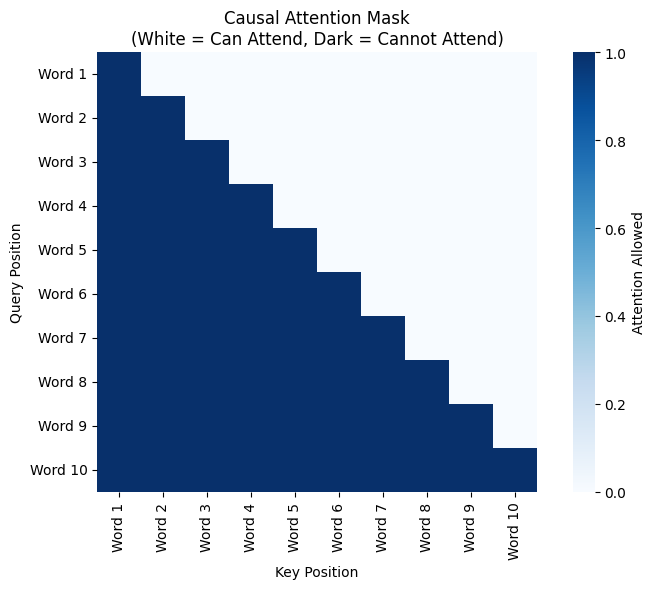

In [3]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns

# Create a simple attention layer
d_model = 256
n_heads = 4
attn = CausalSelfAttention(d_model, n_heads)

# Create a sample input (batch_size=1, seq_len=10)
x = torch.randn(1, 10, d_model)

# Forward pass
output = attn(x)

# Extract attention weights (you'll need to modify the forward method to return them)
# For visualization purposes
seq_len = 10
causal_mask = torch.tril(torch.ones(seq_len, seq_len))

plt.figure(figsize=(8, 6))
sns.heatmap(causal_mask.numpy(), 
            cmap='Blues', 
            square=True,
            cbar_kws={'label': 'Attention Allowed'},
            xticklabels=[f'Word {i+1}' for i in range(seq_len)],
            yticklabels=[f'Word {i+1}' for i in range(seq_len)])
plt.title('Causal Attention Mask\n(White = Can Attend, Dark = Cannot Attend)')
plt.xlabel('Key Position')
plt.ylabel('Query Position')
plt.tight_layout()
plt.savefig('C:/Users/menon/mini-gpt/analysis/causal_mask.png')
print("Saved visualization to C:/Users/menon/mini-gpt/analysis/causal_mask.png")

In [4]:
import torch
import torch.nn as nn
import math

class MiniGPT(nn.Module):
    def __init__(self, vocab_size, d_model=256, n_heads=4, n_layers=4, max_seq_len=128):
        """
        Mini GPT Model
        
        Args:
            vocab_size: Size of vocabulary (8000 in our case)
            d_model: Embedding dimension (256)
            n_heads: Number of attention heads (4)
            n_layers: Number of transformer blocks (4)
            max_seq_len: Maximum sequence length (128)
        """
        super().__init__()
        
        self.d_model = d_model
        self.max_seq_len = max_seq_len
        #Token embeddings: convert token ids to vectors
        self.token_embedding = nn.Embedding(vocab_size, d_model)
        # Positional embeddings: 
        # Final layer normalization
        self.ln_f = nn.LayerNorm(d_model)
        # Output layer: convert vectors back to vocabulary
        self.positional_embedding = nn.Embedding(max_seq_len, d_model)
        # Transformer blocks (we'll build these in Step 6)
        self.transformer_blocks = nn.ModuleList([
            TransformerBlock(d_model, n_heads) 
            for _ in range(n_layers)
        ])
        # Final layer normalization
        self.ln_f = nn.LayerNorm(d_model)
        # Output layer: convert vectors back to vocabulary probabilities
        self.lm_head = nn.Linear(d_model, vocab_size)
        # Initialize weights
        self.apply(self._init_weights)
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            
    def forward(self, idx):
        """
        Forward pass
        
        Args:
            idx: Token indices, shape (batch_size, seq_len)
        
        Returns:
            logits: Predictions, shape (batch_size, seq_len, vocab_size)
        """
        B, T = idx.shape
        
        # Get embeddings
        token_emb = self.token_embedding(idx)  # (B, T, d_model)
        pos = torch.arange(0, T, dtype=torch.long, device=idx.device)
        pos_emb = self.positional_embedding(pos)  # (T, d_model)
        
        # Combine token and positional embeddings
        x = token_emb + pos_emb  # (B, T, d_model)
        
        # Pass through transformer blocks
        for block in self.transformer_blocks:
            x = block(x)
        
        # Final layer norm
        x = self.ln_f(x)
        
        # Project to vocabulary
        logits = self.lm_head(x)  # (B, T, vocab_size)
        
        return logits

# Placeholder for TransformerBlock (Step-6 completed)
class TransformerBlock(nn.Module):
    def __init__(self, d_model, n_heads):
        """
        A single Transformer Block
        
        Contains:
        - Layer Normalization
        - Causal Self-Attention
        - Feed-Forward Network
        - Residual Connections
        
        Args:
            d_model: Embedding dimension (256)
            n_heads: Number of attention heads (4)
        """
        super().__init__()
        
        # Layer Normalization (before attention)
        self.ln1 = nn.LayerNorm(d_model)
        
        # Causal Self-Attention
        self.attn = CausalSelfAttention(d_model, n_heads)
        
        # Layer Normalization (before feed-forward)
        self.ln2 = nn.LayerNorm(d_model)
        
        # Feed-Forward Network
        self.ffn = FeedForwardNetwork(d_model)
    
    def forward(self, x):
        """
        Forward pass with residual connections
        
        Args:
            x: Input tensor, shape (batch_size, seq_len, d_model)
        
        Returns:
            Output tensor, shape (batch_size, seq_len, d_model)
        """
        # Attention block with residual connection
        x = x + self.attn(self.ln1(x))
        
        # Feed-forward block with residual connection
        x = x + self.ffn(self.ln2(x))
        
        return x


class FeedForwardNetwork(nn.Module):
    def __init__(self, d_model, expansion_factor=4):
        """
        Feed-Forward Network
        
        Simple MLP: expand -> activate -> project back
        
        Args:
            d_model: Model dimension (256)
            expansion_factor: How much to expand in the middle (4)
        """
        super().__init__()
        
        hidden_dim = d_model * expansion_factor
        
        self.net = nn.Sequential(
            nn.Linear(d_model, hidden_dim),
            nn.GELU(),  # Activation function
            nn.Linear(hidden_dim, d_model),
            nn.Dropout(0.1)
        )


    def forward(self, x):
        return self.net(x)

Test Mini-GPT - Complete Model

In [5]:
import torch


# Create the model
vocab_size = 8000
model = MiniGPT(
    vocab_size=vocab_size,
    d_model=256,
    n_heads=4,
    n_layers=4,
    max_seq_len=128
)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params:,}")

# Test forward pass
batch_size = 4
seq_len = 10
dummy_input = torch.randint(0, vocab_size, (batch_size, seq_len))

print(f"\nInput shape: {dummy_input.shape}")

with torch.no_grad():  # No gradient calculation for testing
    output = model(dummy_input)

print(f"Output shape: {output.shape}")
print(f"Expected: (batch_size={batch_size}, seq_len={seq_len}, vocab_size={vocab_size})")

# Verify output is valid probability distribution
print(f"\nOutput statistics:")
print(f"  Min: {output.min():.2f}")
print(f"  Max: {output.max():.2f}")
print(f"  Mean: {output.mean():.2f}")

print("\n✓ Model is ready for training!")

Total parameters: 7,296,320

Input shape: torch.Size([4, 10])
Output shape: torch.Size([4, 10, 8000])
Expected: (batch_size=4, seq_len=10, vocab_size=8000)

Output statistics:
  Min: -1.43
  Max: 1.49
  Mean: 0.00

✓ Model is ready for training!


Training The Dataset

In [6]:
import torch
from torch.utils.data import Dataset, DataLoader
import sentencepiece as spm

text_file='C:/Users/menon/mini-gpt/data/input.txt'
tokenizer_model='C:/Users/menon/mini-gpt/tokenizer/tokenizer.model'

class ShakespeareDataset(Dataset):
    def __init__(self, text_file, tokenizer_model, context_length=128):
        """
        Dataset for Shakespeare text
        
        Args:
            text_file: Path to input.txt
            tokenizer_model: Path to tokenizer.model
            context_length: Maximum sequence length
        """
        # Load tokenizer
        self.sp = spm.SentencePieceProcessor()
        self.sp.load(tokenizer_model)
        
        # Load and tokenize text
        with open(text_file, 'r', encoding='utf-8') as f:
            text = f.read()
        
        self.tokens = self.sp.encode_as_ids(text)
        self.context_length = context_length
        
        print(f"Loaded {len(self.tokens):,} tokens")
        print(f"Creating {len(self)} training examples")
    
    def __len__(self):
        # Number of possible context windows
        return len(self.tokens) - self.context_length
    
    def __getitem__(self, idx):
        # Get a chunk of tokens
        chunk = self.tokens[idx:idx + self.context_length + 1]
        
        # Split into input and target
        x = torch.tensor(chunk[:-1], dtype=torch.long)
        y = torch.tensor(chunk[1:], dtype=torch.long)
        
        return x, y

Training Script

Using device: cuda
Loaded 279,430 tokens
Creating 279302 training examples
Model parameters: 7,296,320


Epoch 1/10: 100%|██████████| 4365/4365 [15:10<00:00,  4.80it/s, loss=0.746]


Epoch 1 - Average Loss: 2.3898


Epoch 2/10: 100%|██████████| 4365/4365 [19:30<00:00,  3.73it/s, loss=0.414] 


Epoch 2 - Average Loss: 0.5130


Epoch 3/10: 100%|██████████| 4365/4365 [15:26<00:00,  4.71it/s, loss=0.303]  


Epoch 3 - Average Loss: 0.3520


Epoch 4/10: 100%|██████████| 4365/4365 [09:55<00:00,  7.33it/s, loss=0.285]


Epoch 4 - Average Loss: 0.2890


Epoch 5/10: 100%|██████████| 4365/4365 [09:57<00:00,  7.30it/s, loss=0.233]


Epoch 5 - Average Loss: 0.2538


Epoch 6/10: 100%|██████████| 4365/4365 [09:58<00:00,  7.30it/s, loss=0.212]


Epoch 6 - Average Loss: 0.2307


Epoch 7/10: 100%|██████████| 4365/4365 [09:58<00:00,  7.29it/s, loss=0.25] 


Epoch 7 - Average Loss: 0.2136


Epoch 8/10: 100%|██████████| 4365/4365 [09:07<00:00,  7.97it/s, loss=0.21] 


Epoch 8 - Average Loss: 0.2006


Epoch 9/10: 100%|██████████| 4365/4365 [09:04<00:00,  8.01it/s, loss=0.184]


Epoch 9 - Average Loss: 0.1895


Epoch 10/10: 100%|██████████| 4365/4365 [09:03<00:00,  8.04it/s, loss=0.168]


Epoch 10 - Average Loss: 0.1808

✓ Model saved to model/trained_model.pt
✓ Loss plot saved to analysis/training_loss.png


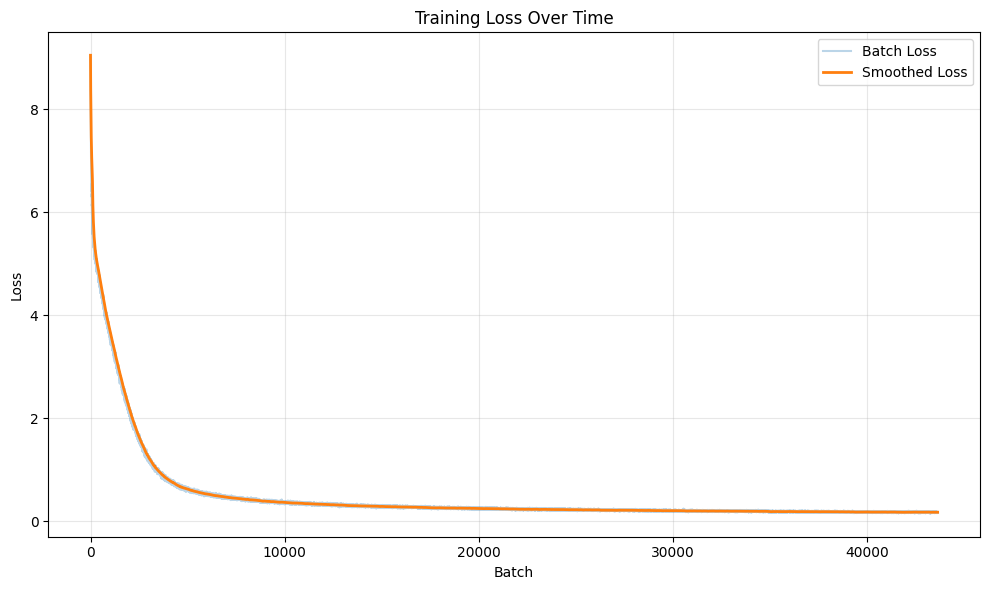

In [7]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm

# Configuration
config = {
    'vocab_size': 8000,
    'd_model': 256,
    'n_heads': 4,
    'n_layers': 4,
    'max_seq_len': 128,
    'batch_size': 64,
    'learning_rate': 3e-4,
    'num_epochs': 10,
    'device': 'cuda' if torch.cuda.is_available() else 'cpu'
}

print(f"Using device: {config['device']}")

# Load dataset
dataset = ShakespeareDataset(
    'C:/Users/menon/mini-gpt/data/input.txt',
    'C:/Users/menon/mini-gpt/tokenizer/tokenizer.model',
    context_length=config['max_seq_len']
)

dataloader = DataLoader(
    dataset,
    batch_size=config['batch_size'],
    shuffle=True,
    num_workers=0
)

# Create model
model = MiniGPT(
    vocab_size=config['vocab_size'],
    d_model=config['d_model'],
    n_heads=config['n_heads'],
    n_layers=config['n_layers'],
    max_seq_len=config['max_seq_len']
).to(config['device'])

print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=config['learning_rate'])

# Training loop
losses = []

for epoch in range(config['num_epochs']):
    model.train()
    epoch_loss = 0
    progress_bar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{config['num_epochs']}")
    
    for batch_idx, (x, y) in enumerate(progress_bar):
        x, y = x.to(config['device']), y.to(config['device'])
        
        # Forward pass
        logits = model(x)  # (batch, seq_len, vocab_size)
        
        # Calculate loss
        # Reshape for cross entropy: (batch * seq_len, vocab_size)
        loss = criterion(
            logits.view(-1, config['vocab_size']),
            y.view(-1)
        )
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        
        # Gradient clipping (prevents exploding gradients)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        # Update weights
        optimizer.step()
        
        # Track loss
        epoch_loss += loss.item()
        losses.append(loss.item())
        
        # Update progress bar
        progress_bar.set_postfix({'loss': loss.item()})
    
    avg_loss = epoch_loss / len(dataloader)
    print(f"Epoch {epoch+1} - Average Loss: {avg_loss:.4f}")

# Save model
torch.save(model.state_dict(), 'C:/Users/menon/mini-gpt/model/trained_model.pt')
print("\n✓ Model saved to model/trained_model.pt")

# Plot training loss
plt.figure(figsize=(10, 6))
plt.plot(losses, alpha=0.3, label='Batch Loss')
# Plot smoothed version
window = 100
smoothed = [sum(losses[max(0,i-window):i+1]) / len(losses[max(0,i-window):i+1]) for i in range(len(losses))]
plt.plot(smoothed, linewidth=2, label='Smoothed Loss')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('C:/Users/menon/mini-gpt/analysis/training_loss.png')
print("✓ Loss plot saved to analysis/training_loss.png")

Sentence generation Script

In [8]:
import torch
import sentencepiece as spm

def generate_text(model, tokenizer, prompt, max_new_tokens=100, temperature=1.0, top_k=None):
    """
    Generate text from the model
    
    Args:
        model: Trained MiniGPT model
        tokenizer: SentencePiece tokenizer
        prompt: Starting text
        max_new_tokens: How many tokens to generate
        temperature: Sampling temperature (higher = more random)
        top_k: If set, only sample from top k tokens
    
    Returns:
        Generated text string
    """
    model.eval()
    
    # Encode the prompt
    tokens = tokenizer.encode_as_ids(prompt)
    tokens = torch.tensor(tokens, dtype=torch.long).unsqueeze(0)  # Add batch dimension
    
    # Generate
    with torch.no_grad():
        for _ in range(max_new_tokens):
            # Get model predictions
            logits = model(tokens)  # (1, seq_len, vocab_size)
            
            # Focus on the last token's predictions
            logits = logits[:, -1, :]  # (1, vocab_size)
            
            # GREEDY DECODING
            if temperature == 0.0:
                next_token = torch.argmax(logits, dim=-1, keepdim=True)
            
            else:
                # Temperature scaling
                logits = logits / temperature
            
                # Optional top-k filtering
                if top_k is not None:
                    v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
                    logits[logits < v[:, [-1]]] = float('-inf')
            
                # Convert to probabilities
                probs = torch.softmax(logits, dim=-1)
            
                # Safety check (optional but recommended)
                probs = torch.clamp(probs, min=1e-8)
            
                # Sample
                next_token = torch.multinomial(probs, num_samples=1)

            
            # Append to sequence
            tokens = torch.cat([tokens, next_token], dim=1)
            
            # Optional: stop if we hit max context length
            if tokens.size(1) >= 128:
                tokens = tokens[:, -128:]  # Keep last 128 tokens
    
    # Decode back to text
    generated_ids = tokens[0].tolist()
    generated_text = tokenizer.decode_ids(generated_ids)
    
    return generated_text


# Load model and tokenizer
config = {
    'vocab_size': 8000,
    'd_model': 256,
    'n_heads': 4,
    'n_layers': 4,
    'max_seq_len': 128
}

model = MiniGPT(**config)
model.load_state_dict(torch.load('C:/Users/menon/mini-gpt/model/trained_model.pt'))
model.eval()

sp = spm.SentencePieceProcessor()
sp.load('C:/Users/menon/mini-gpt/tokenizer/tokenizer.model')

# Generate with different prompts
prompts = [
    "ROMEO:",
    "To be ",
    "The king said",
]

print("=" * 60)
print("GREEDY SAMPLING (temperature=0.0)")
print("=" * 60)
for prompt in prompts:
    generated = generate_text(model, sp, prompt, max_new_tokens=50, temperature=0.0)
    print(f"\nPrompt: {prompt}")
    print(f"Generated: {generated}\n")
    print("-" * 60)

print("\n" + "=" * 60)
print("TEMPERATURE SAMPLING (temperature=0.8)")
print("=" * 60)
for prompt in prompts:
    generated = generate_text(model, sp, prompt, max_new_tokens=50, temperature=0.8)
    print(f"\nPrompt: {prompt}")
    print(f"Generated: {generated}\n")
    print("-" * 60)

print("\n" + "=" * 60)
print("TOP-K SAMPLING (temperature=1.0, top_k=50)")
print("=" * 60)
for prompt in prompts:
    generated = generate_text(model, sp, prompt, max_new_tokens=50, temperature=1.0, top_k=50)
    print(f"\nPrompt: {prompt}")
    print(f"Generated: {generated}\n")
    print("-" * 60)

GREEDY SAMPLING (temperature=0.0)

Prompt: ROMEO:
Generated: ROMEO: I am too sore enpierced with his shaft To soar with his light feathers, and so bound, I cannot bound a pitch above dull woe: Under love's heavy burden do I sink. MERCUTIO: And, to sink

------------------------------------------------------------

Prompt: To be 
Generated: To be a king, Before I have shook off the regal thoughts Wherewith I reign'd? I hardly yet have learn'd To insinuate, flatter, bow, and bend my limbs: Give sorrow leave awhile to tutor me To this submission

------------------------------------------------------------

Prompt: The king said
Generated: The king said so. KING RICHARD II: Speak it again, and speak; what's thy name? CORIOLANUS: If, Tullus, Not yet thou knowest me, and, seeing me, dost not Think me for the man I am, necessity Commands me

------------------------------------------------------------

TEMPERATURE SAMPLING (temperature=0.8)

Prompt: ROMEO:
Generated: ROMEO: Ay, them too, but

Interactive generator

In [9]:
import torch
import sentencepiece as spm

# Load model and tokenizer
config = {
    'vocab_size': 8000,
    'd_model': 256,
    'n_heads': 4,
    'n_layers': 4,
    'max_seq_len': 128
}

model = MiniGPT(**config)
model.load_state_dict(torch.load('C:/Users/menon/mini-gpt/model/trained_model.pt'))
model.eval()

sp = spm.SentencePieceProcessor()
sp.load('C:/Users/menon/mini-gpt/tokenizer/tokenizer.model')

def generate_text(model, tokenizer, prompt, max_new_tokens=100, temperature=0.8):
    model.eval()
    tokens = tokenizer.encode_as_ids(prompt)
    tokens = torch.tensor(tokens, dtype=torch.long).unsqueeze(0)
    
    with torch.no_grad():
        for _ in range(max_new_tokens):
            logits = model(tokens)
            logits = logits[:, -1, :] / temperature
            probs = torch.softmax(logits, dim=-1)
            next_token = torch.multinomial(probs, num_samples=1)
            tokens = torch.cat([tokens, next_token], dim=1)
            
            if tokens.size(1) >= 128:
                tokens = tokens[:, -128:]
    
    return tokenizer.decode_ids(tokens[0].tolist())

# Interactive loop
print("Mini GPT Text Generator")
print("=" * 60)
print("Type a prompt and press Enter to generate text.")
print("Type 'quit' to exit.\n")

while True:
    prompt = input("Prompt: ")
    
    if prompt.lower() == 'quit':
        break
    
    if not prompt:
        continue
    
    print("\nGenerating...")
    generated = generate_text(model, sp, prompt, max_new_tokens=100, temperature=0.8)
    print(f"\n{generated}\n")
    print("-" * 60)

Mini GPT Text Generator
Type a prompt and press Enter to generate text.
Type 'quit' to exit.



Prompt:  I siad



Generating...

I siad. CLIFFORD: Hadst thou didst kill him thy heart-blood, thy father, To bid thy father knowledge, which is a thousand-fold death not have my idolatrav myself, And by my house to obey: I will, if I be but sleep. I know thy taketh most delight In music, instruments and poetry, Schoolmasters will I keep within my house, Fit to instruct her youth. If you, Hortensio, Or Signior Gremio, you,

------------------------------------------------------------


Prompt:  the king siad



Generating...

the king siadors. KING RICHARD II: They are amazed; and thus long have we stood To watch the fearful bending of thy knee, Because we thought ourself thy lawful king: And if we be, how dare thy joints forget To pay their awful duty to our presence? If we be not, show us the hand of God That hath dismissed us from our stewardship; For well we know, no hand of blood and bone Can gripe the sacred handle of our sceptre, Unless he

------------------------------------------------------------


Prompt:  exit



Generating...

exiting those that had encounter As often as you, ambitious as I se heard her, With her double riches of all semblance! Help, three-pence all my house, Fitzwater, I do remember well The very time Aumerle and you did talk. LORD FITZWATER: 'Tis very true: you were in presence then; And you can witness with me this is true. DUKE OF SURREY: As false, by heaven, as heaven itself is true. LORD FITZWATER: Surrey, thou

------------------------------------------------------------


Prompt:  quit


Create Analysis Script

In [15]:
import torch
import sentencepiece as spm
import json

# Load model and tokenizer
config = {
    'vocab_size': 8000,
    'd_model': 256,
    'n_heads': 4,
    'n_layers': 4,
    'max_seq_len': 128
}

model = MiniGPT(**config)
model.load_state_dict(torch.load('C:/Users/menon/mini-gpt/model/trained_model.pt'))
model.eval()

sp = spm.SentencePieceProcessor()
sp.load('C:/Users/menon/mini-gpt/tokenizer/tokenizer.model')

def generate_with_analysis(prompt, max_tokens=50, temperature=0.8):
    """Generate text and analyze the generation process"""
    model.eval()
    tokens = sp.encode_as_ids(prompt)
    tokens_list = tokens.copy()
    text_progression = [prompt]
    
    tokens_tensor = torch.tensor(tokens, dtype=torch.long).unsqueeze(0)
    
    with torch.no_grad():
        for i in range(max_tokens):
            logits = model(tokens_tensor)
            logits = logits[:, -1, :] / temperature
            probs = torch.softmax(logits, dim=-1)
            
            # Get top 5 predictions
            top_probs, top_indices = torch.topk(probs[0], 5)
            
            # Sample next token
            next_token = torch.multinomial(probs, num_samples=1)
            tokens_list.append(next_token.item())
            tokens_tensor = torch.cat([tokens_tensor, next_token], dim=1)
            
            # Decode current text
            current_text = sp.decode_ids(tokens_list)
            text_progression.append(current_text)
            
            # Print analysis for first 10 tokens
            if i < 10:
                print(f"\nStep {i+1}:")
                print(f"Current text: ...{current_text[-50:]}")
                print(f"Top 5 predictions:")
                for prob, idx in zip(top_probs, top_indices):
                    token_text = sp.id_to_piece(idx.item())
                    print(f"  {token_text:20s} {prob.item():.4f}")
                print(f"Chosen: {sp.id_to_piece(next_token.item())}")
            
            if tokens_tensor.size(1) >= 128:
                tokens_tensor = tokens_tensor[:, -128:]
    
    return sp.decode_ids(tokens_list), text_progression


# Analysis 1: Repetition Detection
def detect_repetition(text, n=5):
    """Detect repeating n-grams"""
    words = text.split()
    n_grams = [' '.join(words[i:i+n]) for i in range(len(words)-n+1)]
    
    seen = {}
    repetitions = []
    
    for i, ng in enumerate(n_grams):
        if ng in seen:
            repetitions.append({
                'n_gram': ng,
                'first_pos': seen[ng],
                'second_pos': i
            })
        else:
            seen[ng] = i
    
    return repetitions


# Analysis 2: Context Sensitivity
def test_context_sensitivity():
    """Test how context affects predictions"""
    test_cases = [
        ("ROMEO:", "Short context"),
        ("ROMEO: O, she doth teach the torches to burn bright!", "Longer context"),
        ("JULIET:", "Different character"),
    ]
    
    print("\n" + "="*60)
    print("CONTEXT SENSITIVITY TEST")
    print("="*60)
    
    for prompt, description in test_cases:
        print(f"\n{description}")
        print(f"Prompt: {prompt}")
        generated, _ = generate_with_analysis(prompt, max_tokens=30, temperature=1.2)
        print(f"Generated: {generated}")
        print("-"*60)


# Run analyses
print("="*60)
print("GENERATION ANALYSIS")
print("="*60)

prompt = "To be or not to be"
print(f"\nPrompt: {prompt}\n")
generated_text, progression = generate_with_analysis(prompt, max_tokens=50, temperature=0.8)

print("\n" + "="*60)
print("REPETITION ANALYSIS")
print("="*60)
repetitions = detect_repetition(generated_text, n=3)
if repetitions:
    print(f"\nFound {len(repetitions)} repetitions:")
    for rep in repetitions[:5]:  # Show first 5
        print(f"  '{rep['n_gram']}' repeated at positions {rep['first_pos']} and {rep['second_pos']}")
else:
    print("\nNo significant repetitions found")

# Test context sensitivity
test_context_sensitivity()

# Save examples
examples = {
    'good_examples': [],
    'bad_examples': [],
    'repetitive_examples': [],
}

print("\n" + "="*60)
print("COLLECT EXAMPLES FOR ANALYSIS")
print("="*60)
print("\nGenerating multiple samples to categorize...\n")

test_prompts = ["ROMEO:", "The king", "What is", "To be"]
for prompt in test_prompts:
    for temp in [0.5, 0.8, 1.2]:
        generated, _ = generate_with_analysis(prompt, max_tokens=40, temperature=temp)
        
        # Simple quality assessment
        repetitions = detect_repetition(generated, n=3)
        
        if len(repetitions) > 3:
            examples['repetitive_examples'].append({
                'prompt': prompt,
                'temperature': temp,
                'text': generated
            })
        elif len(generated.split()) > 10 and '\n' in generated:
            examples['good_examples'].append({
                'prompt': prompt,
                'temperature': temp,
                'text': generated
            })
        else:
            examples['bad_examples'].append({
                'prompt': prompt,
                'temperature': temp,
                'text': generated
            })

# Save to file
with open('C:/Users/menon/mini-gpt/analysis/generation_examples.json', 'w') as f:
    json.dump(examples, f, indent=2)

print(f"\n✓ Collected examples:")
print(f"  Good: {len(examples['good_examples'])}")
print(f"  Bad: {len(examples['bad_examples'])}")
print(f"  Repetitive: {len(examples['repetitive_examples'])}")
print(f"\n✓ Saved to analysis/generation_examples.json")

GENERATION ANALYSIS

Prompt: To be or not to be


Step 1:
Current text: ...To be or not to be doubt
Top 5 predictions:
  ▁doubt               0.1072
  ▁ent                 0.1008
  ▁spoken              0.0693
  ▁a                   0.0573
  ▁honest              0.0414
Chosen: ▁doubt

Step 2:
Current text: ...To be or not to be doubted
Top 5 predictions:
  ed                   0.9991
  less                 0.0006
  ?                    0.0001
  ▁You                 0.0000
  ▁Upon                0.0000
Chosen: ed

Step 3:
Current text: ...To be or not to be doubted I
Top 5 predictions:
  ▁there               0.3516
  ▁he                  0.2743
  ▁I                   0.2435
  ▁thou                0.0863
  ▁on                  0.0171
Chosen: ▁I

Step 4:
Current text: ...To be or not to be doubted I,
Top 5 predictions:
  .                    0.3323
  ▁shall               0.3086
  ,                    0.2395
  :                    0.0971
  ▁had                 0.0150
Chosen: ,

Step 5:
Curr

INTERPRETABILITY ANALYSIS

Generating visualizations...

✓ Saved token embeddings visualization
✓ Saved prediction distribution visualization
✓ Saved prediction distribution visualization


C:\Users\menon\AppData\Local\Temp\ipykernel_28148\76956474.py:157: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


✓ Saved layer representations visualization

ANALYSIS COMPLETE

Generated visualizations:
  - analysis/token_embeddings.png
  - analysis/prediction_distribution.png
  - analysis/layer_representations.png

These visualizations help you understand:
  • How the model represents words internally
  • What predictions it's confident about
  • How information flows through layers


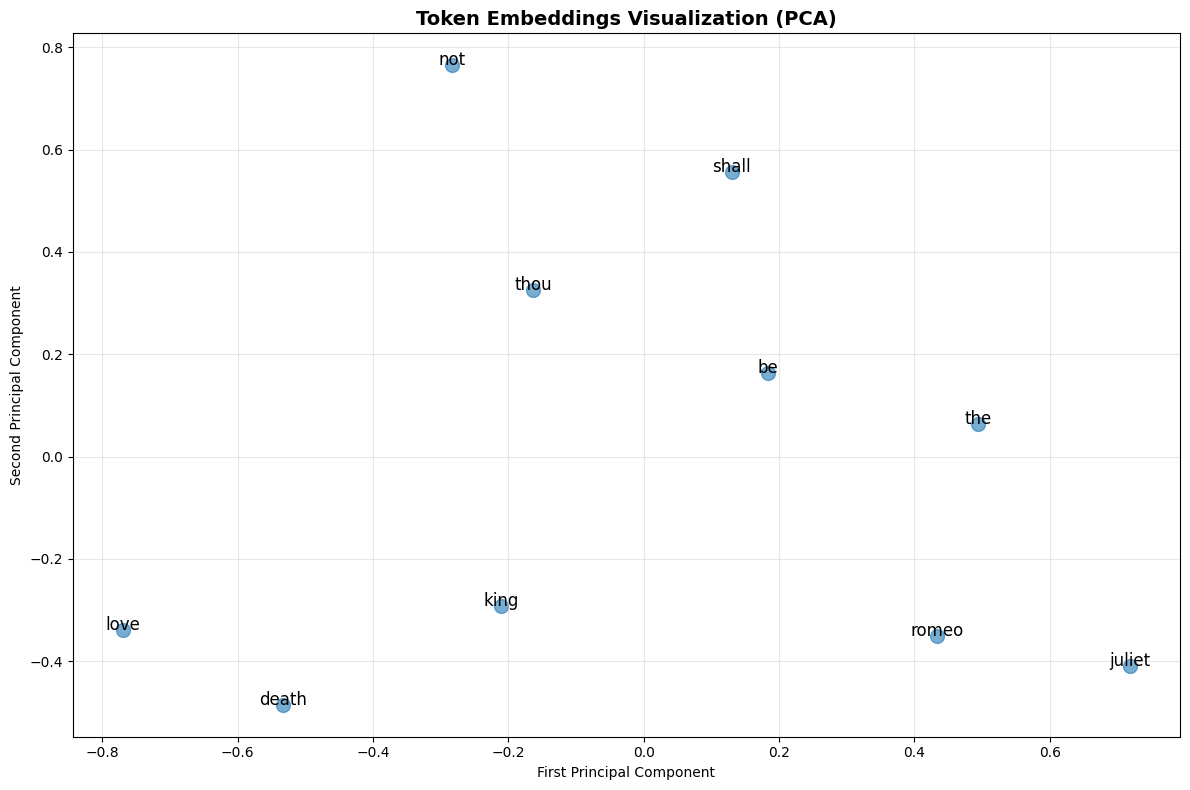

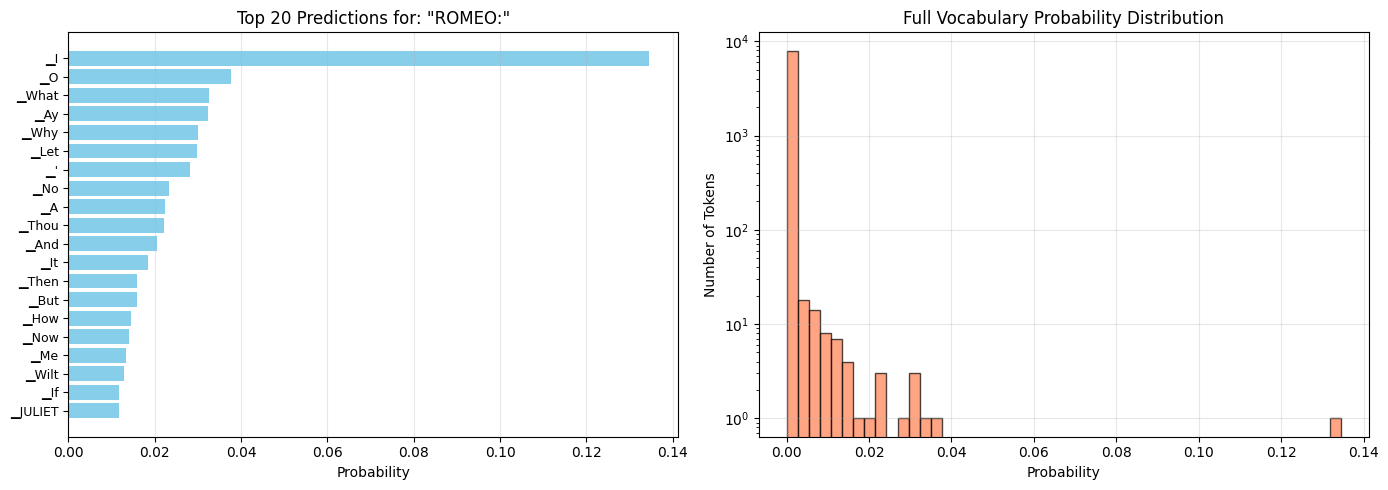

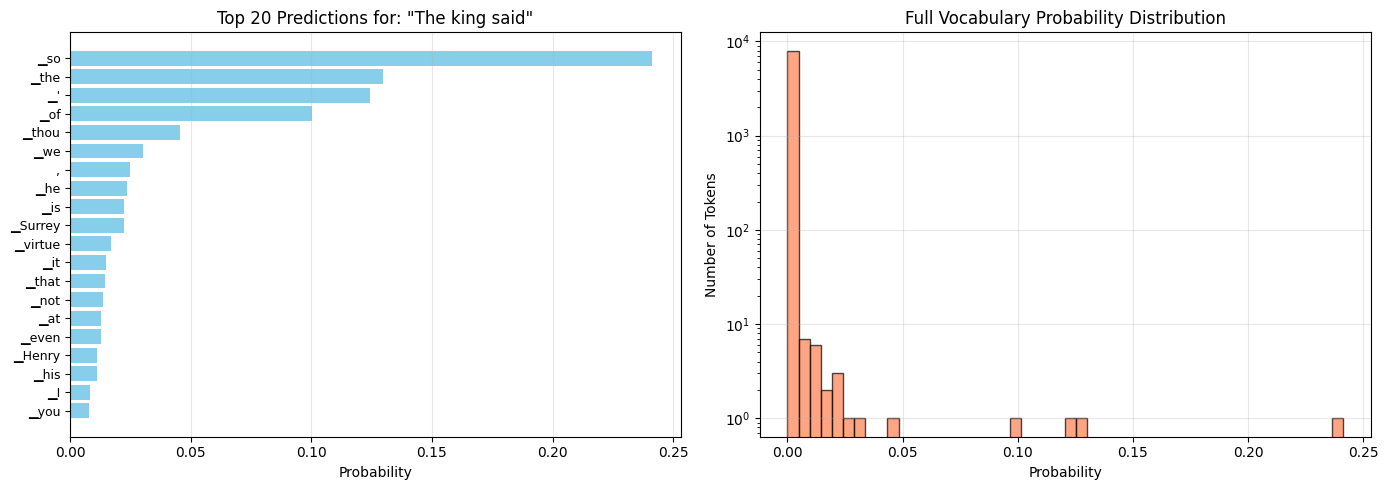

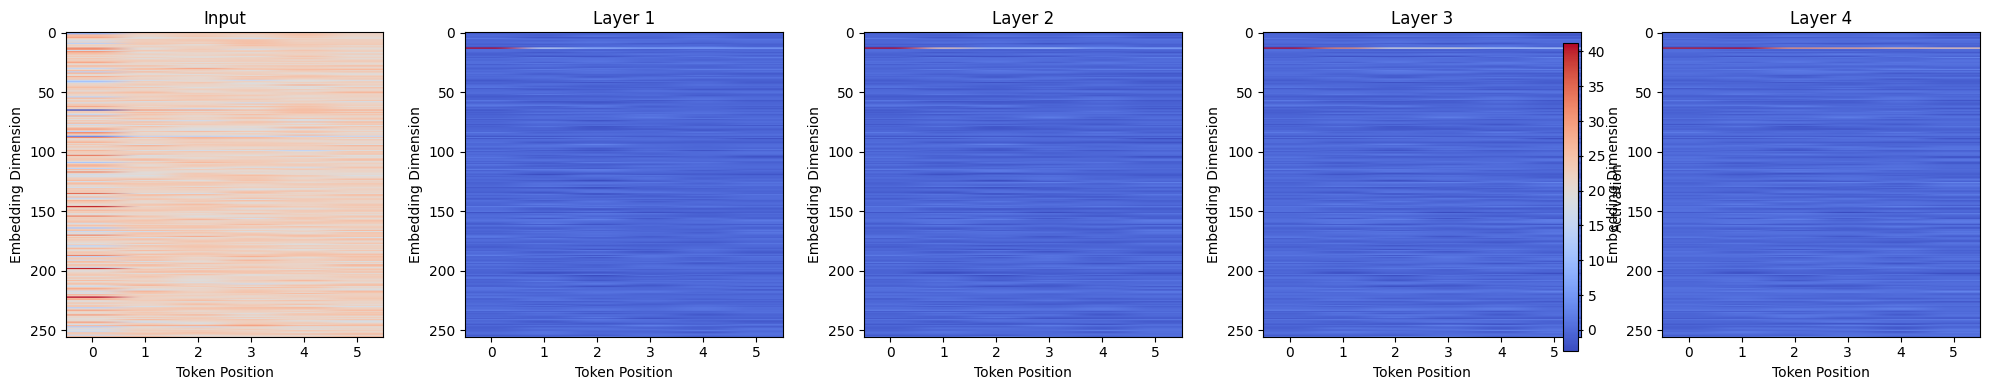

In [20]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sentencepiece as spm

# Load model and tokenizer
config = {
    'vocab_size': 8000,
    'd_model': 256,
    'n_heads': 4,
    'n_layers': 4,
    'max_seq_len': 128
}

model = MiniGPT(**config)
model.load_state_dict(torch.load('C:/Users/menon/mini-gpt/model/trained_model.pt'))
model.eval()

sp = spm.SentencePieceProcessor()
sp.load('C:/Users/menon/mini-gpt/tokenizer/tokenizer.model')


def extract_attention_weights(model, text):
    """
    Extract attention weights from the model
    
    Note: You'll need to modify your model's forward pass
    to return attention weights
    """
    tokens = sp.encode_as_ids(text)
    tokens_tensor = torch.tensor(tokens, dtype=torch.long).unsqueeze(0)
    
    # Store attention weights
    attention_weights = []
    
    def hook_fn(module, input, output):
        # This would capture attention weights if returned
        pass
    
    # You'd register hooks here to capture attention
    # This is a simplified version for demonstration
    
    with torch.no_grad():
        _ = model(tokens_tensor)
    
    return attention_weights, tokens


def visualize_token_embeddings():
    """Visualize token embeddings using PCA"""
    from sklearn.decomposition import PCA
    
    # Get embeddings for some common tokens
    common_words = ["the", "king", "love", "death", "romeo", "juliet", 
                    "thou", "shall", "be", "not"]
    
    token_ids = [sp.encode_as_ids(word)[0] for word in common_words]
    
    # Get embeddings
    embeddings = model.token_embedding.weight[token_ids].detach().cpu().numpy()
    
    # Reduce to 2D using PCA
    pca = PCA(n_components=2)
    embeddings_2d = pca.fit_transform(embeddings)
    
    # Plot
    plt.figure(figsize=(12, 8))
    plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], s=100, alpha=0.6)
    
    for i, word in enumerate(common_words):
        plt.annotate(word, 
                    (embeddings_2d[i, 0], embeddings_2d[i, 1]),
                    fontsize=12,
                    ha='center')
    
    plt.title('Token Embeddings Visualization (PCA)', fontsize=14, fontweight='bold')
    plt.xlabel('First Principal Component')
    plt.ylabel('Second Principal Component')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('C:/Users/menon/mini-gpt/analysis/token_embeddings.png', dpi=150)
    print("✓ Saved token embeddings visualization")


def visualize_logits_distribution(prompt, num_samples=5):
    """Visualize the probability distribution over vocabulary"""
    tokens = sp.encode_as_ids(prompt)
    tokens_tensor = torch.tensor(tokens, dtype=torch.long).unsqueeze(0)
    
    with torch.no_grad():
        logits = model(tokens_tensor)
        probs = torch.softmax(logits[0, -1, :], dim=0)
    
    # Get top predictions
    top_probs, top_indices = torch.topk(probs, 50)
    
    # Create plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Plot 1: Top 20 tokens
    top_20_tokens = [sp.id_to_piece(idx.item()) for idx in top_indices[:20]]
    top_20_probs = top_probs[:20].cpu().numpy()
    
    ax1.barh(range(20), top_20_probs, color='skyblue')
    ax1.set_yticks(range(20))
    ax1.set_yticklabels(top_20_tokens, fontsize=9)
    ax1.invert_yaxis()
    ax1.set_xlabel('Probability')
    ax1.set_title(f'Top 20 Predictions for: "{prompt}"')
    ax1.grid(True, alpha=0.3, axis='x')
    
    # Plot 2: Probability distribution histogram
    all_probs = probs.cpu().numpy()
    ax2.hist(all_probs, bins=50, color='coral', alpha=0.7, edgecolor='black')
    ax2.set_xlabel('Probability')
    ax2.set_ylabel('Number of Tokens')
    ax2.set_title('Full Vocabulary Probability Distribution')
    ax2.set_yscale('log')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('C:/Users/menon/mini-gpt/analysis/prediction_distribution.png', dpi=150)
    print("✓ Saved prediction distribution visualization")


def analyze_layer_outputs():
    """Analyze how representations change through layers"""
    prompt = "To be or not to be"
    tokens = sp.encode_as_ids(prompt)
    tokens_tensor = torch.tensor(tokens, dtype=torch.long).unsqueeze(0)
    
    layer_outputs = []
    
    # Get output after each transformer block
    with torch.no_grad():
        x = model.token_embedding(tokens_tensor)
        pos = torch.arange(0, tokens_tensor.size(1), dtype=torch.long)
        x = x + model.positional_embedding(pos)
        
        layer_outputs.append(x[0].cpu().numpy())
        
        for block in model.transformer_blocks:
            x = block(x)
            layer_outputs.append(x[0].cpu().numpy())
    
    # Visualize how representation changes
    fig, axes = plt.subplots(1, len(layer_outputs), figsize=(20, 4))
    
    for i, (layer_out, ax) in enumerate(zip(layer_outputs, axes)):
        im = ax.imshow(layer_out.T, aspect='auto', cmap='coolwarm')
        ax.set_title(f'Layer {i}' if i > 0 else 'Input')
        ax.set_xlabel('Token Position')
        ax.set_ylabel('Embedding Dimension')
    
    plt.colorbar(im, ax=axes.ravel().tolist(), label='Activation')
    plt.tight_layout()
    plt.savefig('C:/Users/menon/mini-gpt/analysis/layer_representations.png', dpi=150)
    print("✓ Saved layer representations visualization")


# Run visualizations
print("="*60)
print("INTERPRETABILITY ANALYSIS")
print("="*60)
print("\nGenerating visualizations...\n")

visualize_token_embeddings()
visualize_logits_distribution("ROMEO:")
visualize_logits_distribution("The king said")
analyze_layer_outputs()

print("\n" + "="*60)
print("ANALYSIS COMPLETE")
print("="*60)
print("\nGenerated visualizations:")
print("  - analysis/token_embeddings.png")
print("  - analysis/prediction_distribution.png")
print("  - analysis/layer_representations.png")
print("\nThese visualizations help you understand:")
print("  • How the model represents words internally")
print("  • What predictions it's confident about")
print("  • How information flows through layers")